<a href="https://colab.research.google.com/github/Akechi1412/Phishing-Website-Detection/blob/main/app/notebooks/data_preparation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Preprocessing data for Phishing Webpage Detection Model**

## **Connect to Drive and Github responsitory**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd /content/drive/MyDrive/Github
%cd Phishing-Website-Detection/app
!git config --global user.email 'nguyenphong10042002@gmail.com'
!git config --global user.name 'Akechi1412'
!git fetch origin
!git reset --hard origin/main

/content/drive/MyDrive/Github
/content/drive/MyDrive/Github/Phishing-Website-Detection/app
Updating files: 100% (15/15), done.
HEAD is now at b48ff3b Update something


## **Load data**

In [3]:
!pip install aiohttp

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.8/64.8 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 22.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 241.9/241.9 kB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.6/124.6 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 318.7/318.7 kB 14.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 208.9/208.9 kB 13.1 MB/s eta 0:00:00


In [4]:
from utils.data_preparing import load_data
from utils.data_preprocessing import parse_html
import gc

In [5]:
data_size = 51000
data_train, data_val, data_test = load_data(limit=data_size)

In [6]:
print(len(data_train), len(data_val), len(data_test))
print(data_train[0].keys())

81600 10200 10200
dict_keys(['url', 'html', 'label'])


In [7]:
# Extracting train data
url_train = [item['url'] for item in data_train]
html_train = [item['html'] for item in data_train]
label_train = [item['label'] for item in data_train]

# Extracting validation data
url_val = [item['url'] for item in data_val]
html_val = [item['html'] for item in data_val]
label_val = [item['label'] for item in data_val]

# Extracting test data
url_test = [item['url'] for item in data_test]
html_test = [item['html'] for item in data_test]
label_test = [item['label'] for item in data_test]

In [8]:
del data_train, data_val, data_test
gc.collect()

50

## **Create word-based URL representation**

In [9]:
from utils.data_preprocessing import split_url, build_dictionary, vectorize_url
from collections import Counter
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

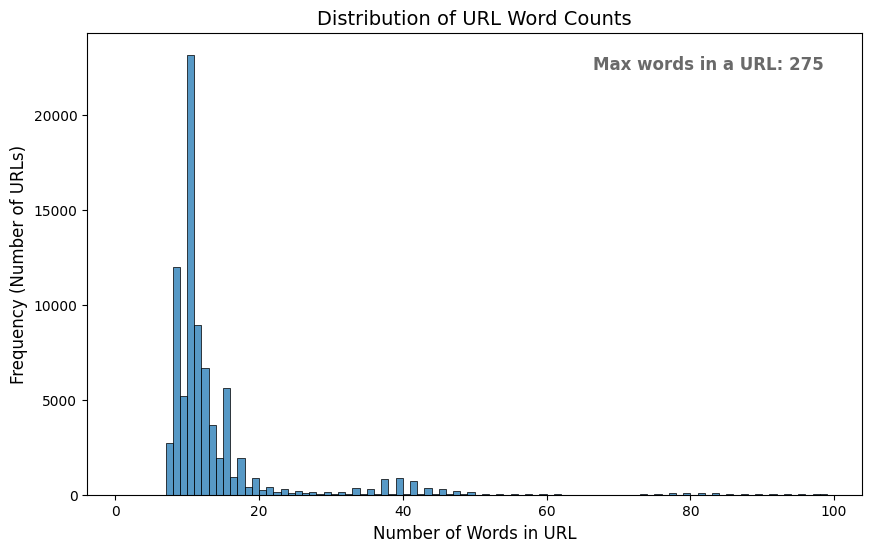

In [10]:
word_counts = [len(split_url(url)) for url in url_train]
max_word_count = max(word_counts)

plt.figure(figsize=(10, 6))
sns.histplot(word_counts, bins=range(1, 100), kde=False)
plt.title('Distribution of URL Word Counts', fontsize=14)
plt.xlabel('Number of Words in URL', fontsize=12)
plt.ylabel('Frequency (Number of URLs)', fontsize=12)
plt.text(
    x=0.95, y=0.95,
    s=f'Max words in a URL: {max_word_count}',
    color='dimgray', fontsize=12, fontweight='bold', ha='right', va='top',
    transform=plt.gca().transAxes
)
plt.show()

Set `max_words` to 50.

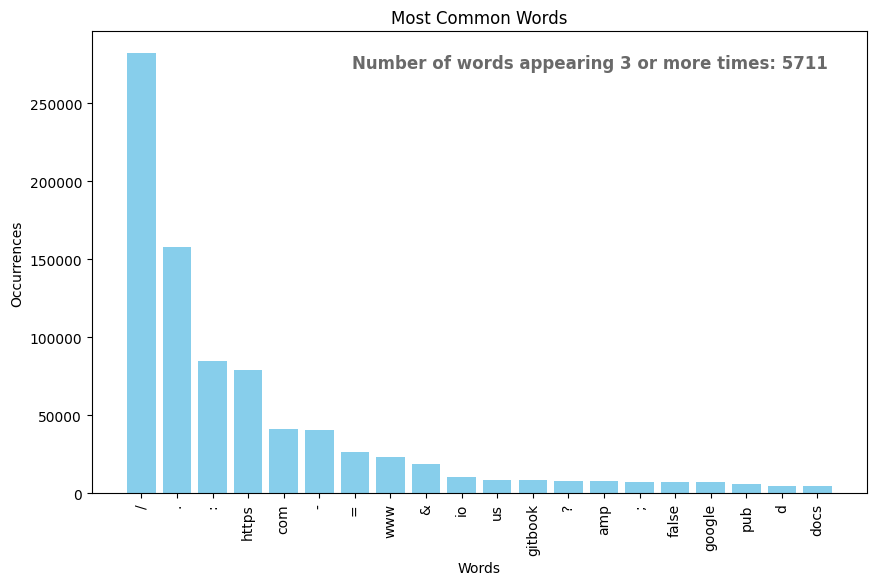

In [11]:
words = [word for url in url_train for word in split_url(url)]
word_counts = Counter(words)
common_words = {word: count for word, count in word_counts.items() if count >= 3}
most_common_words = Counter(common_words).most_common(20)
labels, values = zip(*most_common_words)
num_common_words = len(common_words)

plt.figure(figsize=(10, 6))
plt.bar(labels, values, color='skyblue')
plt.xlabel('Words')
plt.ylabel('Occurrences')
plt.title('Most Common Words')
plt.xticks(rotation=90)
plt.text(
    x=0.95, y=0.95, s=f'Number of words appearing 3 or more times: {num_common_words}',
    color='dimgray', fontsize=12, fontweight='bold', ha='right', va='top',
    transform=plt.gca().transAxes
)
plt.show()

Set `vocab_size` to 6000.

In [12]:
vocab_size = 6000

filename = 'models/dictionary.pkl'
dictionary = build_dictionary(words, vocab_size=vocab_size, filename=filename)

def create_urls_representation(urls, dictionary, max_words):
    vectorized_urls = []
    for url in urls:
        vectorized_url = vectorize_url(url, dictionary, max_words=max_words)
        vectorized_urls.append(vectorized_url)
    return np.array(vectorized_urls)

Dictionary saved to models/dictionary.pkl


## **Create graph-based HTML DOM representation**

In [13]:
from utils.data_preprocessing import parse_html, create_graph, create_graph_adjacency, create_graph_feature
import numpy as np
from concurrent.futures import ProcessPoolExecutor

In [14]:
def count_nodes(html):
    dom_tree = parse_html(html)
    graph = create_graph(dom_tree)
    return len(graph.nodes())

def calculate_node_statistics(htmls, max_workers=12):
    node_counts = []
    with ProcessPoolExecutor(max_workers=max_workers) as executor:
        node_counts = list(executor.map(count_nodes, html_train))
    return node_counts

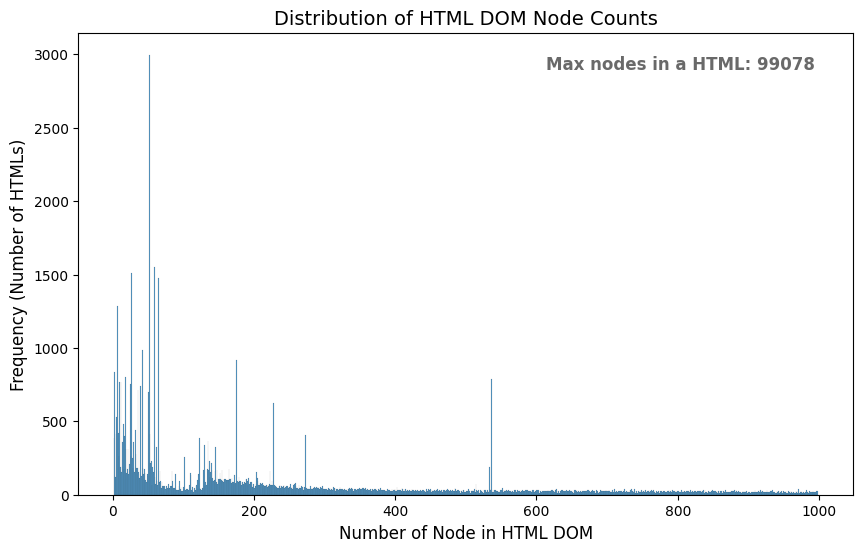

In [15]:
node_counts = calculate_node_statistics(html_train)
max_node_count = max(node_counts)

plt.figure(figsize=(10, 6))
sns.histplot(node_counts, bins=range(1, 1000), kde=False)
plt.title('Distribution of HTML DOM Node Counts', fontsize=14)
plt.xlabel('Number of Node in HTML DOM', fontsize=12)
plt.ylabel('Frequency (Number of HTMLs)', fontsize=12)
plt.text(
    x=0.95, y=0.95, s=f'Max nodes in a HTML: {max_node_count}',
    color='dimgray', fontsize=12, fontweight='bold', ha='right', va='top',
    transform=plt.gca().transAxes
)
plt.show()

Set `max_nodes` to 600.

In [16]:
def process_html(html, max_nodes):
    dom_tree = parse_html(html)
    graph = create_graph(dom_tree)
    adjacency = create_graph_adjacency(graph, max_nodes=max_nodes)
    feature = create_graph_feature(graph, max_nodes=max_nodes)
    return adjacency, feature

def create_htmls_representation(htmls, max_nodes, max_workers=12):
    with ProcessPoolExecutor(max_workers=max_workers) as executor:
        results = list(executor.map(process_html, htmls, [max_nodes]*len(htmls)))

    adjacencies = np.array([result[0] for result in results])
    features = np.array([result[1] for result in results])

    return adjacencies, features

## **Preprocess and save train, val and test data**

In [17]:
import h5py

In [18]:
def save_batch_data(file_path, urls, adjacencies, features, labels):
    with h5py.File(file_path, 'a') as f:
        if 'url' not in f:
            f.create_dataset('url', shape=(0, urls.shape[1]),
                             maxshape=(None, urls.shape[1]), compression='gzip')
            f.create_dataset('adjacency', shape=(0, adjacencies.shape[1], adjacencies.shape[2]),
                             maxshape=(None, adjacencies.shape[1], adjacencies.shape[2]), compression='gzip')
            f.create_dataset('feature', shape=(0, features.shape[1], features.shape[2]),
                             maxshape=(None, features.shape[1], features.shape[2]), compression='gzip')
            f.create_dataset('label', shape=(0,),
                             maxshape=(None,), compression='gzip')

        current_size = f['url'].shape[0]
        new_size = current_size + urls.shape[0]

        f['url'].resize((new_size, urls.shape[1]))
        f['adjacency'].resize((new_size, adjacencies.shape[1], adjacencies.shape[2]))
        f['feature'].resize((new_size, features.shape[1], features.shape[2]))
        f['label'].resize((new_size,))

        f['url'][current_size:new_size] = urls
        f['adjacency'][current_size:new_size] = adjacencies
        f['feature'][current_size:new_size] = features
        f['label'][current_size:new_size] = labels

In [19]:
batch_size = 10200
max_words = 50
max_nodes = 600

for i in range(0, len(url_train), batch_size):
    urls_batch = create_urls_representation(url_train[i:i + batch_size], dictionary, max_words)
    adj_batch, feat_batch = create_htmls_representation(html_train[i:i + batch_size], max_nodes)
    labels_batch = np.array(label_train[i:i + batch_size])
    save_batch_data('data/train.h5', urls_batch, adj_batch, feat_batch, labels_batch)

for i in range(0, len(url_val), batch_size):
    urls_batch = create_urls_representation(url_val[i:i + batch_size], dictionary, max_words)
    adj_batch, feat_batch = create_htmls_representation(html_val[i:i + batch_size], max_nodes)
    labels_batch = np.array(label_val[i:i + batch_size])
    save_batch_data('data/val.h5', urls_batch, adj_batch, feat_batch, labels_batch)

for i in range(0, len(url_test), batch_size):
    urls_batch = create_urls_representation(url_test[i:i + batch_size], dictionary, max_words)
    adj_batch, feat_batch = create_htmls_representation(html_test[i:i + batch_size], max_nodes)
    labels_batch = np.array(label_test[i:i + batch_size])
    save_batch_data('data/test.h5', urls_batch, adj_batch, feat_batch, labels_batch)